# Non-linearity example

Slava Kisilevich
kisilevich.slava@gmail.com

In [88]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotnine import *


import statsmodels.api as sm

In [89]:
from pygam import LinearGAM, s

In [90]:
#
spend = np.random.rand(1000, 1).reshape(-1)
noise = np.random.normal(size = 1000, scale = 0.2)

#hill transformation
alpha = 2
gamma = 0.1

spend_transformed = spend**alpha / (spend ** alpha + gamma ** alpha) 

response = 1 + 3 * spend_transformed  +  noise


In [91]:
data = pd.DataFrame({"spend": spend, "spend_transformed": spend_transformed, "response": response})

In [92]:
data

,spend,spend_transformed,response
0,0.952577,0.989100,4.122791
1,0.299703,0.899821,3.486419
2,0.573646,0.970508,4.175728
3,0.941210,0.988838,4.058410
4,0.707846,0.980432,3.926608
...,...,...,...
995,0.612851,0.974065,4.103095
996,0.201185,0.801884,3.565112
997,0.710713,0.980587,3.934721
998,0.873740,0.987070,4.424951


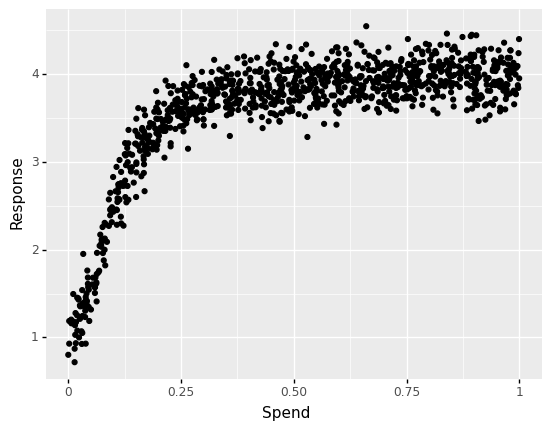

<ggplot: (165734435091)>

In [93]:
ggplot(data, aes("spend", "response")) + geom_point() + xlab("Spend") + ylab("Response")

## Linear Regression 

In [94]:
spend_with_intercept = sm.add_constant(spend)
ols_model = sm.OLS(response, spend_with_intercept)
ols_results = ols_model.fit()
ols_results.params

array([2.66854185, 1.78295723])

In [95]:
data["predict_linear"] = ols_results.predict(spend_with_intercept)

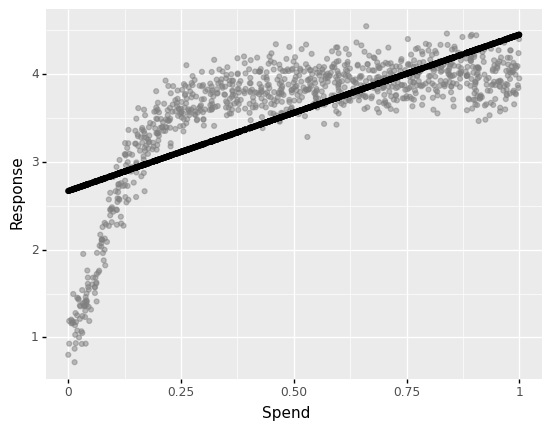

<ggplot: (165730588480)>

In [96]:
ggplot(data, aes("spend", "response")) + geom_point(alpha = 0.5, color = "grey")\
+ geom_point(aes("spend", "predict_linear")) + xlab("Spend") + ylab("Response")

## Linear Regression with hill-transformed variable

In [97]:
alpha = 2
gamma = 0.3
spend_transformed = spend**alpha / (spend ** alpha + gamma ** alpha) 

X_hill_transformed = sm.add_constant(spend_transformed)
ols_model_hill_transformed = sm.OLS(response, X_hill_transformed)
ols_results_hill_transformed = ols_model_hill_transformed.fit()
ols_results_hill_transformed.params

array([2.25516054, 2.1139317 ])

In [98]:
data["predict_hill_transformed"] = ols_results_hill_transformed.predict(X_hill_transformed)

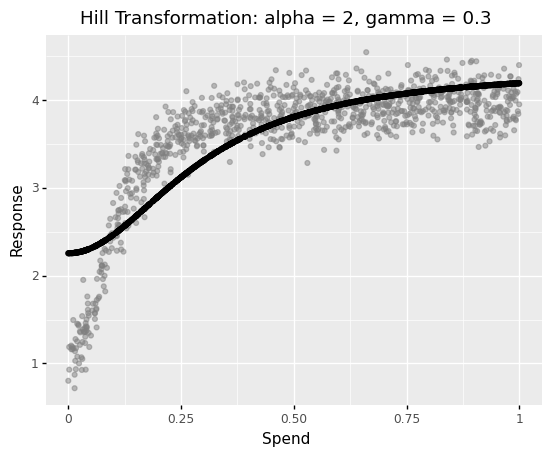

<ggplot: (165734445861)>

In [99]:
ggplot(data, aes("spend", "response")) + geom_point(alpha = 0.5, color = "grey")\
+ geom_point(aes("spend", "predict_hill_transformed")) + xlab("Spend") + ylab("Response") + ggtitle(f"Hill Transformation: alpha = {alpha}, gamma = {gamma}") 

In [100]:
alpha = 2
gamma = 0.15
spend_transformed = spend**alpha / (spend ** alpha + gamma ** alpha) 

X_hill_transformed = sm.add_constant(spend_transformed)
ols_model_hill_transformed = sm.OLS(response, X_hill_transformed)
ols_results_hill_transformed = ols_model_hill_transformed.fit()
ols_results_hill_transformed.params

array([1.504817 , 2.6117151])

In [101]:
data["predict_hill_transformed"] = ols_results_hill_transformed.predict(X_hill_transformed)

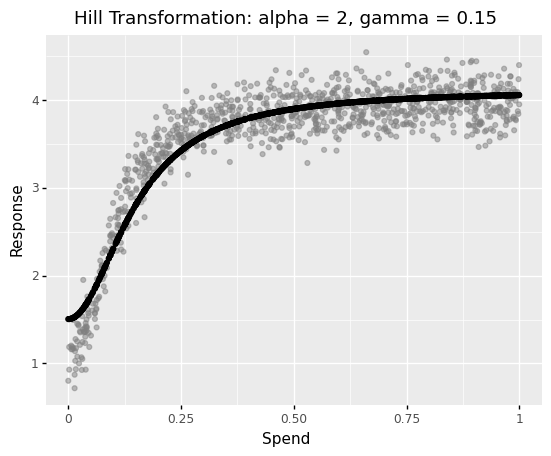

<ggplot: (165733038406)>

In [102]:
ggplot(data, aes("spend", "response")) + geom_point(alpha = 0.5, color = "grey")\
+ geom_point(aes("spend", "predict_hill_transformed")) + xlab("Spend") + ylab("Response") + ggtitle(f"Hill Transformation: alpha = {alpha}, gamma = {gamma}") 

## Regression Splines with pyGAM

In [103]:
gam_hill = LinearGAM(s(0, n_splines=10), lam = 0.1).fit(spend, response)

In [104]:
gam_hill.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.4481
Link Function:                     IdentityLink Log Likelihood:                                -10385.9303
Number of Samples:                         1000 AIC:                                            20790.7568
                                                AICc:                                           20790.9563
                                                GCV:                                                0.0396
                                                Scale:                                               0.039
                                                Pseudo R-Squared:                                   0.9273
Feature Function                  Lam

C:\Users\kisilevich\AppData\Local\Temp\ipykernel_9744\1066930177.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [105]:
gam_hill.coef_

array([-4.06286588, -2.03859426,  0.57089546,  0.98818756,  1.05096755,
        1.14878929,  1.13676706,  1.28866903,  1.07387469,  1.6163343 ,
        2.77302487])

In [106]:
len(gam_hill.coef_)

11

In [107]:
gam_hill.coef_[-1]

2.7730248666864483

In [108]:
XX = gam_hill.generate_X_grid(term=0, n = len(response))
YY = gam_hill.partial_dependence(term=0, X=XX)
#add intercept
intercept_ = gam_hill.coef_[-1]
response_prediction = intercept_ + YY 

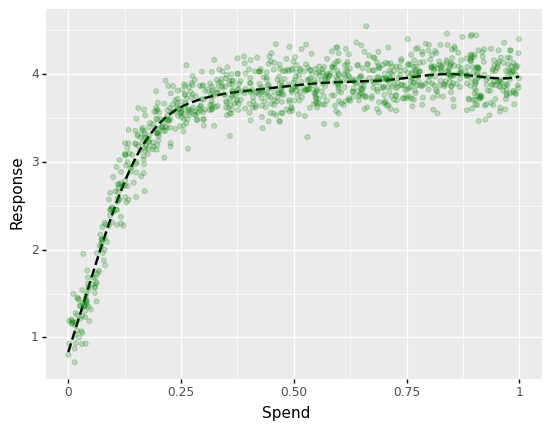

<ggplot: (165731795866)>

In [109]:
temp_data = pd.DataFrame(np.concatenate([XX, response_prediction.reshape(-1,1), response.reshape(-1, 1), spend.reshape(-1, 1)], axis =1 ), columns = ["XX", "y_pred", "y", "x"])
ggplot(temp_data, aes("XX", "y_pred")) + geom_line(size = 1, linetype = "dashed") + geom_point(aes("x", "y"), alpha = 0.2, color = "green") + xlab("Spend") + ylab("Response")

In [110]:
basis_functions = pd.DataFrame(gam_hill._modelmat(spend).toarray())
basis_functions["spend"] = spend

In [111]:
basis_functions

,0,1,2,3,4,5,6,7,8,9,10,spend
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005899,3.670334e-01,0.576564,0.050503,1.0,0.952577
1,0.0,0.000000,0.122043,0.657413,0.220384,0.000160,0.000000,0.000000e+00,0.000000,0.000000,1.0,0.299703
2,0.0,0.000000,0.000000,0.000000,0.158081,0.666364,0.175554,8.894781e-07,0.000000,0.000000,1.0,0.573646
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.011316,4.199080e-01,0.534189,0.034588,1.0,0.941210
4,0.0,0.000000,0.000000,0.000000,0.000013,0.188799,0.664896,1.462924e-01,0.000000,0.000000,1.0,0.707846
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.000000,0.000000,0.000000,0.059128,0.593813,0.342906,4.153130e-03,0.000000,0.000000,1.0,0.612851
996,0.0,0.034474,0.533820,0.420337,0.011370,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.0,0.201185
997,0.0,0.000000,0.000000,0.000000,0.000002,0.178136,0.666169,1.556940e-01,0.000000,0.000000,1.0,0.710713
998,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.113787,6.532476e-01,0.232682,0.000284,1.0,0.873740


In [112]:
gam_hill.coef_

array([-4.06286588, -2.03859426,  0.57089546,  0.98818756,  1.05096755,
        1.14878929,  1.13676706,  1.28866903,  1.07387469,  1.6163343 ,
        2.77302487])

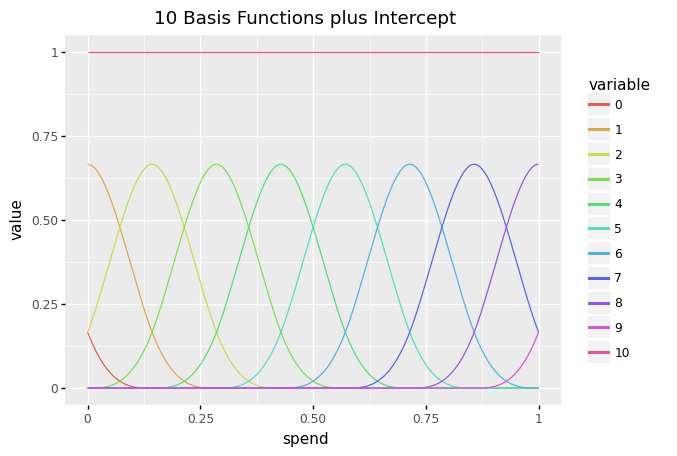

<ggplot: (165731785719)>

In [113]:
ggplot(pd.melt(basis_functions, id_vars="spend"), aes("spend", "value", group="variable", color = "variable")) + geom_line() + ggtitle(f"{len(basis_functions.columns) - 2} Basis Functions plus Intercept")

In [114]:
basis = gam_hill._modelmat(spend).toarray()  
coefficients = gam_hill.coef_
spline = basis[:,:-1] @ coefficients[:-1]

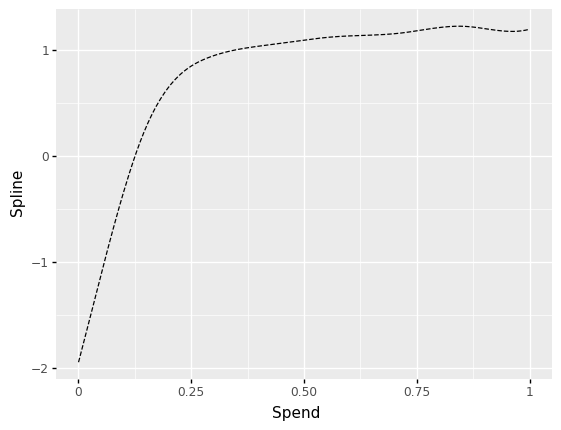

<ggplot: (165721350931)>

In [115]:
temp = pd.DataFrame(spline, columns = ["Spline"])
temp["Spend"] = spend
ggplot(temp, aes("Spend", "Spline")) + geom_line(linetype = "dashed")